In [3]:
# import libraries
import pandas as pd; import numpy as np; import matplotlib.pyplot as plt; import seaborn as sns; import re;
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.corpus import stopwords; from nltk.stem import WordNetLemmatizer; from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from collections import Counter
from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec
import multiprocessing
from time import time

%matplotlib inline

In [4]:
# read in data
df = pd.read_csv("../Data/DataPrepQ2.csv", low_memory=False)

In [5]:
# view df at high level
df.head()

,listing_id,id_x,date,reviewer_id,reviewer_name,comments,id_y,summary,description,neighbourhood_cleansed,review_scores_rating
0,4826,3419,2009-06-01,13823,Anja,We just came back from a weeks stay at Kaan's ...,4826,My place is close to great views. My place is ...,My place is close to great views. My place is ...,Uskudar,100.0
1,20815,31174,2010-03-24,49388,Chuck,My daughter and her friend and I all stayed at...,20815,Watch The Bosphorus from The Comfy Hill. A spa...,Watch The Bosphorus from The Comfy Hill. A spa...,Besiktas,90.0
2,20815,40738,2010-05-08,93598,Sara,You cannot find a better place to stay in Turk...,20815,Watch The Bosphorus from The Comfy Hill. A spa...,Watch The Bosphorus from The Comfy Hill. A spa...,Besiktas,90.0
3,20815,49182,2010-06-02,108540,Suzan,This comfortable apartment truly deserves the ...,20815,Watch The Bosphorus from The Comfy Hill. A spa...,Watch The Bosphorus from The Comfy Hill. A spa...,Besiktas,90.0
4,20815,85462,2010-08-27,126482,William,I second all the excellent reviews of this pla...,20815,Watch The Bosphorus from The Comfy Hill. A spa...,Watch The Bosphorus from The Comfy Hill. A spa...,Besiktas,90.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195780 entries, 0 to 195779
Data columns (total 11 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   listing_id              195780 non-null  int64  
 1   id_x                    195780 non-null  int64  
 2   date                    195780 non-null  object 
 3   reviewer_id             195780 non-null  int64  
 4   reviewer_name           195780 non-null  object 
 5   comments                195521 non-null  object 
 6   id_y                    195780 non-null  int64  
 7   summary                 183428 non-null  object 
 8   description             193388 non-null  object 
 9   neighbourhood_cleansed  195780 non-null  object 
 10  review_scores_rating    195142 non-null  float64
dtypes: float64(1), int64(4), object(6)
memory usage: 16.4+ MB


In [7]:
# remove rows with empty comments
df = df.dropna(subset=['comments'], axis=0)

In [8]:
# clean the reviewer comments
def clean_comment(comment):
    comment = re.sub(r"[^a-zA-Z ]", "", comment.lower())
    comment_tokens = word_tokenize(comment)
    stops = set(stopwords.words('english'))
    comment_cleaned = ' '.join(word for word in comment_tokens if word not in stops)
    return comment_cleaned


In [9]:
clean_comments = []
for i in df.comments:
    clean_comments.append(clean_comment(i))

In [10]:
# new feature containing cleaned comments
df['comment_cleaned'] = clean_comments

In [11]:
# join all comments together for wordcloud
comments = ' '.join(comment for comment in clean_comments)
comments_tokenized = word_tokenize(comments)
counter = Counter(comments_tokenized)

In [12]:
counter.most_common(10)

[('place', 75197),
 ('great', 72204),
 ('apartment', 68540),
 ('location', 57463),
 ('stay', 55515),
 ('istanbul', 46776),
 ('host', 44951),
 ('nice', 44363),
 ('clean', 41910),
 ('us', 41825)]

In [13]:
comments = ' '.join(word for word in comments_tokenized if word not in ['istanbul'])

In [16]:
wc = WordCloud(background_color='white').generate(comments)

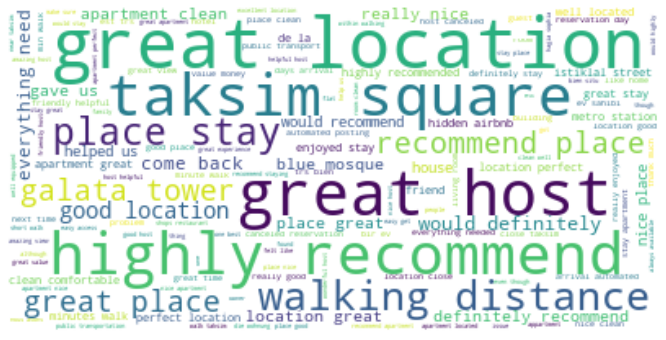

In [17]:
plt.figure(figsize=(18,6))
plt.imshow(wc, interpolation='bilinear');
plt.axis("off");
plt.savefig("../Static/wc_1.png")

In [18]:
kadikoy_wc = WordCloud(background_color='white').generate()
plt.figure(figsize=(18,6))
plt.imshow(kadikoy_wc, interpolation='bilinear');
plt.axis("off");
plt.savefig("../Static/wc_2.png")

NameError: name 'text' is not defined

In [ ]:
fatih_comments = ' '.join(comment for comment in df.loc[df.neighbourhood_cleansed == 'Fatih', 'comment_cleaned'])
fatih_wc = WordCloud(background_color='white').generate(text)
plt.figure(figsize=(18,6))
plt.imshow(fatih_wc, interpolation='bilinear')
plt.axis("off")
plt.show()
plt.savefig("../Static/wc_3.png")

In [19]:
# assess comment quality
df['comment_len'] = df.comment_cleaned.str.split().str.len()
df['comment_unique_len'] = df.comment_cleaned.apply(lambda x: len(set(x.split())))
df['comment_quality'] = df.comment_unique_len / df.comment_len

In [20]:
# remove comments that had less than 3 words - these won't prove useful for word2vec model
df_1 = df.loc[df.comment_len > 3].copy()

In [21]:
# convert comments to list of lists for preparation for phraser
comments = [word_tokenize(comment) for comment in df_1.comment_cleaned]

In [22]:
# find phrases in documents
phrases = Phrases(comments, min_count=30)

In [23]:
# build bigram phraser
bigrams = Phraser(phrases)

In [24]:
# transform corpus by identifying all relevant bigrams
comments_w_bigrams = bigrams[comments]

In [18]:
# identify number of cores available to train word2vec model
cores = multiprocessing.cpu_count()

In [20]:
# create w2v model with params initialized
#w2v_model = Word2Vec(sg=1, hs=1, min_count=50, window=2, size=300, sample=1e-5, alpha=0.03, min_alpha=0.0006, negative=20, workers=cores-1, iter=3, seed=37)
# build the vocab for w2v model
#t = time()

#w2v_model.build_vocab(comments_w_bigrams, progress_per=10000)

#print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))
# train the w2v model on the comment data
#t = time()

#w2v_model.train(comments_w_bigrams, total_examples=w2v_model.corpus_count, epochs=10)

#print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

In [25]:
# make the model memory efficient after training
#w2v_model.init_sims(replace=True)

In [25]:
w2v_model = Word2Vec.load("../Models/word_2_vec_comments.model")

In [26]:
# check the results of the model
w2v_model.wv.most_similar(positive=['great'])

[('amazing', 0.7668002247810364),
 ('awesome', 0.7641927003860474),
 ('perfect', 0.7346498966217041),
 ('wonderful', 0.7198468446731567),
 ('highly_recommended', 0.7192769050598145),
 ('really', 0.6984049081802368),
 ('good', 0.6972649097442627),
 ('highly_recommend', 0.6950176358222961),
 ('fantastic', 0.6937698125839233),
 ('location', 0.693158745765686)]

In [27]:
w2v_model.wv.most_similar(positive=['ferry'])

[('ferries', 0.7675091028213501),
 ('pier', 0.6957144737243652),
 ('take_ferry', 0.6801434755325317),
 ('kadikoy', 0.6687135100364685),
 ('asian_side', 0.6622865796089172),
 ('european_side', 0.6615545749664307),
 ('ferry_station', 0.6602094173431396),
 ('ferry_terminal', 0.6580735445022583),
 ('port', 0.6572026610374451),
 ('marmaray', 0.6471282243728638)]

In [28]:
w2v_model.wv.most_similar(positive=["culture", "food"], negative=["location"], topn=3)

[('turkish', 0.5209288001060486),
 ('discussions', 0.4918050765991211),
 ('history', 0.4840219020843506)]

In [33]:
# persist the w2v model
#w2v_model.save("../Models/word_2_vec_comments.model")

In [29]:
# apply kmeans model to word vectors to identify langauge
kmeans_model = KMeans(n_clusters=4, n_init=20, max_iter=1000, random_state=37)

In [30]:
cluster_comments = kmeans_model.fit(w2v_model.wv.vectors)

In [31]:
w2v_model.wv.similar_by_vector(kmeans_model.cluster_centers_[3], topn=10, restrict_vocab=None)

[('bir', 0.880141019821167),
 ('ev', 0.86890709400177),
 ('gzel', 0.8585542440414429),
 ('ayrca', 0.8583550453186035),
 ('ancak', 0.8379968404769897),
 ('daha', 0.8368375301361084),
 ('iin', 0.8365836143493652),
 ('rahat', 0.8352181911468506),
 ('zellikle', 0.8306886553764343),
 ('ise', 0.8300820589065552)]

In [32]:
# assign labels to words - first create new df for terms, vectors and cluster assignments
terms_df = pd.DataFrame(w2v_model.wv.vocab.keys())
terms_df.columns = ['term']

In [33]:
terms_df['vector'] = terms_df.term.apply(lambda x: w2v_model.wv[f"{x}"])

In [34]:
terms_df['cluster'] = terms_df.vector.apply(lambda x: kmeans_model.predict([np.array(x)]))

In [35]:
terms_df.cluster = terms_df.cluster.apply(lambda x: x[0])

In [36]:
terms_df.head()

,term,vector,cluster
0,came_back,"[-0.008817731, 0.057169832, -0.024302248, 0.00...",1
1,weeks,"[0.10963966, 0.0849386, 0.028239317, -0.007276...",1
2,stay,"[0.12136386, 0.06508104, 0.03630459, -0.041549...",1
3,apartment,"[0.14439917, 0.03958666, 0.057837404, -0.01291...",1
4,loved,"[0.14644483, 0.021480171, -0.002340784, 0.0003...",1


In [37]:
# filter english terms
english_terms = set(terms_df.loc[terms_df.cluster == 1, 'term'].values)

In [38]:
# make new df showing comments
df_1['comment'] = [i for i in comments_w_bigrams]

In [39]:
# create new feature showing number of words in comment that are from english terms
df_1['language'] = df_1.comment.apply(lambda x: len([word for word in x if word in english_terms]))

In [40]:
# new df for english comments
english_df = df_1.loc[df_1.language > 0].copy()

In [41]:
# determine if comment has enough english words to be considered english
english_df.language = english_df.apply(lambda x: 'English' if x['language'] / len(x['comment']) >= .5 else 'Foreign', axis=1)

In [42]:
# filter on language column
english_df = english_df.loc[english_df.language == 'English']

In [43]:
english_df.sample(10)

,listing_id,id_x,date,reviewer_id,reviewer_name,comments,id_y,summary,description,neighbourhood_cleansed,review_scores_rating,comment_cleaned,comment_len,comment_unique_len,comment_quality,comment,language
37983,3304098,53305898,2015-11-07,12396780,Maurits,"Very nice, polite, helpful, English speaking g...",3304098,In the heart of Istanbul where all attractions...,In the heart of Istanbul where all attractions...,Beyoglu,92.0,nice polite helpful english speaking girl plac...,27,26,0.962963,"[nice, polite, helpful, english_speaking, girl...",English
14553,908653,173949835,2017-07-24,72391203,Anton,Overall great budget stay !!,908653,"This is bright 1-room apartment, located in T...","This is bright 1-room apartment, located in T...",Beyoglu,95.0,overall great budget stay,4,4,1.000000,"[overall, great, budget, stay]",English
22693,1230718,232534008,2018-02-05,164801465,Yuyuan,very convenient location and comfortable plac...,1230718,''Pashas House'' is in the heart of the histor...,''Pashas House'' is in the heart of the histor...,Fatih,95.0,convenient location comfortable place least st...,8,8,1.000000,"[convenient, location, comfortable, place, lea...",English
24,20815,79643992,2016-06-13,22721139,Baskut,A nice simple apartment with a great view in a...,20815,Watch The Bosphorus from The Comfy Hill. A spa...,Watch The Bosphorus from The Comfy Hill. A spa...,Besiktas,90.0,nice simple apartment great view good location...,10,9,0.900000,"[nice, simple, apartment, great, view, good, l...",English
57692,5644556,38058602,2015-07-12,16686859,Krishna,We had a wonderful time at Galata Tower VIP Ap...,5644556,This is a newly renovated apartment in a histo...,This is a newly renovated apartment in a histo...,Beyoglu,85.0,wonderful time galata tower vip apartments loc...,60,59,0.983333,"[wonderful, time, galata_tower, vip, apartment...",English
183984,37982605,563517796,2019-11-13,33723095,Alexis,Wonderful stay at Fatih's. The appartment is v...,37982605,The apartment is situated at an elite quarter ...,The apartment is situated at an elite quarter ...,Beyoglu,100.0,wonderful stay fatihs appartment well located ...,16,15,0.937500,"[wonderful, stay, fatihs, appartment, well_loc...",English
35772,2985376,22673099,2014-11-11,7402127,Anthony,The host's representative was timely and helpf...,2985376,The flat (80 m2) has 2 double sleeping rooms a...,The flat (80 m2) has 2 double sleeping rooms a...,Beyoglu,94.0,hosts representative timely helpful flat spaci...,26,26,1.000000,"[hosts, representative, timely, helpful, flat,...",English
115304,22682048,444502963,2019-04-28,245244338,Olivier,"Perfect location in Istanbul, just 5min walk t...",22682048,The apartment is located by 100 meters from th...,The apartment is located by 100 meters from th...,Beyoglu,96.0,perfect location istanbul min walk metro tramw...,24,22,0.916667,"[perfect, location, istanbul, min_walk, metro,...",English
48515,4584562,211914812,2017-11-15,71534987,Denisa,We enjoyed our stay at Alihan's place. Nice an...,4584562,This is a cozy private room with ensuite bathr...,This is a cozy private room with ensuite bathr...,Fatih,91.0,enjoyed stay alihans place nice cozy good price,8,8,1.000000,"[enjoyed_stay, alihans, place, nice, cozy, goo...",English
137356,28401040,545297932,2019-10-12,3659498,Ellina,Amazing location and extremely beautiful apart...,28401040,"Şehrin en gözde semtinin göbeğinde, modern ve ...","Şehrin en gözde semtinin göbeğinde, modern ve ...",Sisli,98.0,amazing location extremely beautiful apartment...,20,20,1.000000,"[amazing, location, extremely, beautiful, apar...",English


In [44]:
w2v_model.wv.most_similar("turkish")

[('english', 0.5686886310577393),
 ('food', 0.5678949356079102),
 ('local_culture', 0.5601766109466553),
 ('locals', 0.5592986345291138),
 ('language', 0.5567449927330017),
 ('delicious', 0.5513635873794556),
 ('learn', 0.5459684133529663),
 ('local', 0.5445338487625122),
 ('learning', 0.5434199571609497),
 ('turkish_culture', 0.5400017499923706)]

In [45]:
def restrict_w2v(w2v, restricted_word_set):
    new_vectors = []
    new_vocab = {}
    new_index2entity = []
    new_vectors_norm = []

    for i in range(len(w2v.wv.vocab)):
        word = w2v.wv.index2entity[i]
        vec = w2v.wv.vectors[i]
        vocab = w2v.wv.vocab[word]
        vec_norm = w2v.wv.vectors_norm[i]
        if word in restricted_word_set:
            vocab.index = len(new_index2entity)
            new_index2entity.append(word)
            new_vocab[word] = vocab
            new_vectors.append(vec)
            new_vectors_norm.append(vec_norm)

    w2v.wv.vocab = new_vocab
    w2v.wv.vectors = np.array(new_vectors)
    w2v.wv.index2entity = np.array(new_index2entity)
    w2v.wv.index2word = np.array(new_index2entity)
    w2v.wv.vectors_norm = np.array(new_vectors_norm)
    
    return w2v

In [46]:
# create english w2v model
english_w2v = restrict_w2v(w2v_model, english_terms)

In [47]:
# create kmeans on english comments
english_kmeans = KMeans(n_clusters=13, n_init=20, max_iter=1000, random_state=37)
cluster_english = english_kmeans.fit(english_w2v.wv.vectors)

In [48]:
# check results of model
english_w2v.wv.similar_by_vector(english_kmeans.cluster_centers_[7], topn=20)

[('buses', 0.7347108125686646),
 ('bus_stop', 0.7334233522415161),
 ('bus_station', 0.7318099141120911),
 ('ferry', 0.727907121181488),
 ('subway', 0.7232745289802551),
 ('metro_station', 0.7211447358131409),
 ('take', 0.7204360961914062),
 ('min_walk', 0.7133404612541199),
 ('minutes_walk', 0.7120323181152344),
 ('taksim_square', 0.7107235193252563),
 ('bus_stops', 0.7078344225883484),
 ('metro', 0.7069299221038818),
 ('stops', 0.7064574956893921),
 ('minutes', 0.7046405076980591),
 ('pier', 0.7017534375190735),
 ('metro_lines', 0.697770357131958),
 ('mins', 0.6976408362388611),
 ('train', 0.6975709795951843),
 ('stop', 0.6973103284835815),
 ('ferry_station', 0.6969348788261414)]

In [49]:
english_w2v.wv.similar_by_vector(english_kmeans.cluster_centers_[12], topn=20)

[('delicious', 0.7899388074874878),
 ('food', 0.7721359729766846),
 ('coffee', 0.7580487728118896),
 ('pastries', 0.7477786540985107),
 ('shop', 0.7243868112564087),
 ('sweets', 0.7168543338775635),
 ('foods', 0.7154241800308228),
 ('juice', 0.7149456739425659),
 ('breakfast', 0.7101773023605347),
 ('bread', 0.7093871831893921),
 ('tasty', 0.7081373929977417),
 ('yummy', 0.7077721357345581),
 ('fresh', 0.7043357491493225),
 ('traditional_turkish', 0.7037296891212463),
 ('around_corner', 0.6992841958999634),
 ('drinks', 0.698009729385376),
 ('delicious_turkish', 0.6978676319122314),
 ('buy', 0.6972285509109497),
 ('pastry', 0.6967357397079468),
 ('fresh_bread', 0.6964704990386963)]

In [50]:
# create names for topics
topics_map = {0:'authentic, charming, beautiful neighbourhood', 1:'helpful host', 2: 'general host', 3: 'difficulties and things to be aware', 4: 'negatives',
             5: 'positive stay', 6: 'all about the views', 7: 'transport', 8: 'accommodation essentials', 9: 'proximity to tourist stuff', 10: 'good location',
             11:'turkish names', 12: 'food and drink'}

In [51]:
# create new df for clusters of english terms
english_terms_df = pd.DataFrame(english_w2v.wv.vocab.keys())
english_terms_df.columns = ['terms']
english_terms_df['vectors'] = english_terms_df.terms.apply(lambda x: english_w2v.wv[f'{x}'])
english_terms_df['cluster'] = english_terms_df.vectors.apply(lambda x: english_kmeans.predict([np.array(x)]))
english_terms_df.cluster = english_terms_df.cluster.apply(lambda x: x[0])
english_terms_df.cluster = english_terms_df.cluster.map(topics_map)

In [52]:
english_terms_df.head()

,terms,vectors,cluster
0,place,"[0.09719277, 0.020596983, -0.008942136, -0.003...",good location
1,great,"[0.14350513, 0.09043725, -0.045027528, -0.0969...",good location
2,apartment,"[0.14439917, 0.03958666, 0.057837404, -0.01291...",good location
3,location,"[0.17206489, 0.0006612921, -0.008534451, -0.10...",good location
4,stay,"[0.12136386, 0.06508104, 0.03630459, -0.041549...",positive stay


In [53]:
# create dictionary of terms and clusters
term_clusters = dict(zip(english_terms_df['terms'], english_terms_df['cluster']))

In [54]:
# create list of english terms to keep
term_keys = set(term_clusters.keys())

In [55]:
for i in english_df.comment:
    for j in i:
        if j not in term_keys:
            i.remove(j)

In [56]:
max_features = pd.Series(' '.join(i for i in english_df.comment.str.join(' ')).split()).nunique()

In [57]:
max_features

22972

In [58]:
# create tfidf
tfidf_vect = TfidfVectorizer(ngram_range=(1,1), norm='l2', sublinear_tf=True, smooth_idf=True, min_df=1, max_df=1., max_features=max_features)

In [59]:
tfidf_comments = tfidf_vect.fit_transform(english_df.comment.str.join(' '))

In [60]:
comment_features = tfidf_vect.get_feature_names()

In [61]:
from scipy.sparse import coo_matrix
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)

In [62]:
def extract_topn_from_vector(feature_names, sorted_items, english_terms, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]
 
    score_vals = []
    feature_vals = []
    cluster_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        term = feature_names[idx]
        if term in english_terms:
            score_vals.append(round(score, 3))
            feature_vals.append(term)
            cluster_vals.append(term_clusters[term])
        
 
    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=[score_vals[idx], cluster_vals[idx]]
    
    return results

In [63]:
sorted_items=sort_coo(tfidf_comments[0].tocoo())
#extract only the top n; n here is 10
keywords=extract_topn_from_vector(comment_features,sorted_items,english_terms, 10)
 
# now print the results
print("\nAbstract:")
print(english_df.comment.str.join(' ')[0])
print("\nKeywords:")
for k in keywords:
    print(k,keywords[k])


Abstract:
came_back weeks stay apartment loved place described shown_pictures tidy beautifully_furnished comfortable food daily essentials houses location great especially prefer stay crowded rather touristy place even_though city_centre easy_get downtown particularly enjoyed option ferry centre mins views onto bridge nighttime bosporus made even_better theres also plenty little shops places_eat close host awesome well generous kind inviting showing_us around explaining culture us fun around absolutely made_sure wed feel_home great couldnt_asked would_definitely recommend_anyone

Keywords:
nighttime [0.185, 'all about the views']
beautifully_furnished [0.179, 'good location']
showing_us [0.167, 'helpful host']
inviting [0.166, 'authentic, charming, beautiful neighbourhood']
explaining [0.166, 'helpful host']
onto [0.162, 'all about the views']
couldnt_asked [0.16, 'good location']
wed [0.156, 'general host']
downtown [0.154, 'proximity to tourist stuff']
essentials [0.153, 'accommodat

In [64]:
sorted_items_list = []
for i in tfidf_comments:
    sorted_items_list.append(sort_coo(i.tocoo()))

In [65]:
keywords_list = []
for i in sorted_items_list:
    keywords_list.append(extract_topn_from_vector(comment_features, i, english_terms, 10))

In [66]:
themes = []
for i in keywords_list:
    themes.append([j[1] for j in i.values()])

themes = [list(set(i)) for i in themes]

In [67]:
# add themes of comment to df
english_df['comment_themes'] = themes

In [68]:
english_df.comment_themes = english_df.comment_themes.str.join(', ')

In [69]:
english_df = english_df.drop(['id_x', 'id_y'], axis=1)

In [70]:
english_df

,listing_id,date,reviewer_id,reviewer_name,comments,summary,description,neighbourhood_cleansed,review_scores_rating,comment_cleaned,comment_len,comment_unique_len,comment_quality,comment,language,comment_themes
0,4826,2009-06-01,13823,Anja,We just came back from a weeks stay at Kaan's ...,My place is close to great views. My place is ...,My place is close to great views. My place is ...,Uskudar,100.0,came back weeks stay kaans apartment loved pla...,90,82,0.911111,"[came_back, weeks, stay, apartment, loved, pla...",English,"good location, general host, helpful host, acc..."
1,20815,2010-03-24,49388,Chuck,My daughter and her friend and I all stayed at...,Watch The Bosphorus from The Comfy Hill. A spa...,Watch The Bosphorus from The Comfy Hill. A spa...,Besiktas,90.0,daughter friend stayed apt owned gulder husban...,113,90,0.796460,"[daughter, friend, stayed, apt, owned, husband...",English,"good location, positive stay, general host, ac..."
2,20815,2010-05-08,93598,Sara,You cannot find a better place to stay in Turk...,Watch The Bosphorus from The Comfy Hill. A spa...,Watch The Bosphorus from The Comfy Hill. A spa...,Besiktas,90.0,find better place stay turkey firat basar imag...,99,85,0.858586,"[find, better, place, stay, turkey, firat, ima...",English,"positive stay, general host, helpful host, tur..."
3,20815,2010-06-02,108540,Suzan,This comfortable apartment truly deserves the ...,Watch The Bosphorus from The Comfy Hill. A spa...,Watch The Bosphorus from The Comfy Hill. A spa...,Besiktas,90.0,comfortable apartment truly deserves name bosp...,216,182,0.842593,"[comfortable, apartment, truly, deserves, name...",English,"good location, helpful host, accommodation ess..."
4,20815,2010-08-27,126482,William,I second all the excellent reviews of this pla...,Watch The Bosphorus from The Comfy Hill. A spa...,Watch The Bosphorus from The Comfy Hill. A spa...,Besiktas,90.0,second excellent reviews place neighborhood lo...,40,39,0.975000,"[second, excellent, reviews, place, neighborho...",English,"good location, general host, helpful host, acc..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195757,43076769,2020-04-01,342887152,Ahmet,Very nice and warm host and very flexible.\nVe...,NaN,NaN,Beyoglu,100.0,nice warm host flexiblevery fast replies also ...,20,16,0.800000,"[nice, warm, host, fast, replies, also, fast, ...",English,"good location, proximity to tourist stuff, hel..."
195759,43104164,2020-04-06,123258114,Selver Asu,Cinar place was absolutely what we were lookin...,galatanın kalbinde huzurlu geniş bir teras katı,galatanın kalbinde huzurlu geniş bir teras kat...,Beyoglu,100.0,cinar place absolutely looking easily fit mayb...,32,31,0.968750,"[place, absolutely, looking, easily, fit, mayb...",English,"positive stay, helpful host, accommodation ess..."
195760,43104474,2020-04-20,161090247,Onur,Aşkın’s place is perfect for a stay in İstanbu...,Geniş ve ferah bir daire. Gerek duyulan her eş...,Geniş ve ferah bir daire. Gerek duyulan her eş...,Beyoglu,100.0,akns place perfect stay istanbulthe location g...,20,19,0.950000,"[place, perfect, stay, istanbulthe, location, ...",English,"good location, positive stay, general host"
195773,43155442,2020-04-14,343818311,Анастасия,very nice residence. but amazing side is the f...,NaN,NaN,Atasehir,100.0,nice residence amazing side flatit well decora...,39,36,0.923077,"[nice, residence, amazing, side, well_decorate...",English,"good location, accommodation essentials, posit..."


In [76]:
english_df = english_df.reset_index(drop=True)

In [101]:
english_df.comments[10455]

"Isik's flat is very cozy and clean. The location is really close to taksim square which means very covenient for shopping, dining and transportation. Isik is very cosiderate that he even prepared the transportation card for us. In his flat, everything you will need is prepared, even a turkish coffee pot. It makes us feel we stay at home. The only drawback is during weekend the night club music downstair is loud."

In [102]:
english_df.comment_themes[10455]

'good location, helpful host, accommodation essentials, turkish names, difficulties and things to be aware, negatives, food and drink, authentic, charming, beautiful neighbourhood'

In [103]:
english_w2v.wv.most_similar('culture')

[('history', 0.6251012682914734),
 ('turkish_culture', 0.5574772357940674),
 ('learn', 0.5400067567825317),
 ('discussions', 0.5350602865219116),
 ('local_culture', 0.5303925275802612),
 ('dubai', 0.526940107345581),
 ('knowledge', 0.5252484083175659),
 ('insight', 0.5223596096038818),
 ('tulum', 0.5193666815757751),
 ('knows', 0.5118342638015747)]

In [92]:
english_df[english_df.comment_themes == 'negatives'].comments[108508]

'The place was noisy outside and inside, the floor was too noisy because of the old wooden parquet, bathroom had mold and smells bad, also was licking however the lick stoped after I let the neighbor knows. NO AIR CONDITIONER. A homeless man was sleeping exactly in front of the entrance , so annoying. The water warmer was inside the bedroom next to the bed , I didn’t feel safe at all and when I told to the owner she claimed it’s legal but still was noisy and annoying. Finally  I didn’t have a pleasant experience staying there. She was trying to makes everything ok button most of them weren’t fixable at the moment. The property is too old and need a real renovation. And the last thing I was full of mosquito’s bites after staying there.'

In [86]:
english_df[english_df.comment_themes.str.contains('negative')].comment_themes[2]

'positive stay, general host, helpful host, turkish names, negatives, food and drink, all about the views'